<h1 align="center">Round 4.2 - Data Augmentation</h1>


This notebook is a part of teaching material for CS-EJ3311 - Deep Learning with Python 13.09.-17.12.2021\
Aalto University (Espoo, Finland)\
fitech.io (Finland)

As a rule of thumb, the number of labeled data points used for the training of ANN should be at least as large as the number of tunable parameters (weights, bias terms) of ANN. Since typical ANN structures involve millions of tunable parameters, we often have too few data points in the training set. 

One powerful approach to train ANN on relatively small training sets is **data augmentation**. The idea behind data augmentation is to enrich or augment the original training dataset by simple variations of the training samples. Consider a deep learning method that aims at classifying an image as either "cat" or "dog". 

To obtain a "cat vs. dog" classifier we could train a deep neural network on some cat images and some dog images (the labeled training data). The idea of data augmentation is to **artificially** augment the training set by creating **synthetic** data points. For example, by rotating a training image. A rotated image of a cat is still a cat image. Moreover, a shifted (translated) cat image is also still a cat image. The same applies to dog images. A rotated or shifted dog image is still showing a dog. 

One method to implement data augmentation is via the concept of **data generators**. A data generator is somewhat like a programming interface that allows separating the code of the training algorithm (e.g., stochastic gradient descent) and the data storage system. This is very convenient for deep learning methods as the data can be stored in vastly different systems, ranging from a standard file system on a hard disk all the way to a cloud computing environment. 

## Learning goals

- use tf.Dataset to train ANNs on large datasets. 
- understand the basic idea of data augmentation. 
- implement data augmentation using Keras preprocessing layer.  

## Recommended Reading

-  [A survey on Image Data Augmentation for Deep Learning](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0)
- [Data augmentation for improving deep learning in image classification problem](https://ieeexplore.ieee.org/abstract/document/8388338)


## Additional Material (Optional!)

- [Building a data pipeline](https://cs230.stanford.edu/blog/datapipeline)
- [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) 
- [Image Augmentation using TensorFlow](https://benihime91.github.io/blog/deeplearning/tensorflow2.x/data_augmentation/image/2020/11/15/image-augmentation-tensorflow.html)

In [7]:
# import Python packages and libraries

import tensorflow as tf                  # provides functionality to train neural network
from tensorflow.keras import optimizers
import numpy as np                       # provides mathematical functions to operate on arrays and matrices
import os                                # library to interact with operating system
import matplotlib.pyplot as plt          # library for generating plots
import pathlib                           # library to perform filesystem interactions
import pandas as pd

## Data

We will use "Cats and Dogs" dataset discussed in previous notebook.

In [8]:
# The path to the dataset
base_dir = pathlib.Path.cwd() / '..' / '..' /  '..' / 'coursedata' / 'cats_and_dogs_small'

# directories for training,
# validation and test splits
train_dir = base_dir / 'train' 
validation_dir =  base_dir / 'validation'
test_dir = base_dir / 'test'

Let's start by training a CNN without data augmentation. We will use similar data pipeline described in the notebook [Tensor Flow Input Pipeline](Round4.1_TensorFlowData.ipynb). First, we need to set some parameters that will help us to define the model in a generic way and experiment with different values easily.

In [9]:
CLASS_NAMES = ['cats', 'dogs']
BATCH_SIZE = 32
IMG_SIZE = 150
EPOCHS = 20

For each image file, we perform following steps:

* Read content of the file. This operation reads the raw bytes contained in the image as a string
* Decode the file content. There are many image formats that we can use. For this specific example, all the images are encoded in the JPEG format. This operation will create a tensor of shape (with, height, channels)
* Resize the image to the values defined above. This goal is to reduce the amount of processing power needed to process the dataset.
* Scale the images. The original pixels values are between 0 and 255. In this step we normalize those values to have then in the interval [0, 1].
* One-hot-encode the image label

All this steps are performed by the function `load_image` that receives as its first argument the path to the image.

In [10]:
def load_image(image_path):
    # load image
    image = tf.io.read_file(image_path)    # read the image from disk
    image = tf.io.decode_jpeg(image, channels=3)    # decode jpeg  
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])    # resize
    image = (image / 255)    # scale 
    
    # get lable value from path
    parts = tf.strings.split(image_path, os.path.sep)    # parse the class label from the file path
    one_hot = parts[-2] == CLASS_NAMES    # select only part with class name and create boolean array
    label = tf.argmax(one_hot)    # get label as integer from boolean array
    
    return (image, label)

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(batch_size=BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.list_files(str(base_dir/'train/*/*.jpg'))
val_ds   = tf.data.Dataset.list_files(str(base_dir/'validation/*/*.jpg'))
test_ds  = tf.data.Dataset.list_files(str(base_dir/'test/*/*.jpg'))


with tf.device('/cpu:0'):
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE)

    train_ds = configure_for_performance(train_ds, shuffle=True)
    val_ds   = configure_for_performance(val_ds)
    test_ds  = configure_for_performance(test_ds)

The line `with tf.device('/cpu:0'):` indicates that the transformations of the images should be performed on the CPU and not on the GPU. This is considered a good practice to make sure that the GPU is only used for training the deep neural network model. More on that in this article: [Building a data pipeline (Stanford University)](https://cs230.stanford.edu/blog/datapipeline/#best-practices).

<div class=" alert alert-warning">
    <h3><b>Student task.</b> CNN training without Data augmentation.</h3>
        
Your task is to build a Convolutional Neural Network for training on the "cats vs dogs" dataset. We recommend the following architecture:

We will use an ANN consisting of the following layers:
 
- 3 blocks of:
   1. Conv2D layer with 32 units, kernel size (3,3), activation ReLU
   2. Max pooling layer, kernel size (2,2)

    
- flattening layer
- dense layer with 128 units and ReLU activation
- output layer with **1 unit** and **sigmoid** activation
 
    
Use `train_ds` and `val_ds` for training (about 20 epochs). Save your model as 'model.h5'.\
Accuracy evaluated on `test_ds` should be **above 0.60**.
    
</div>

In [12]:
# set trainig=False when validating or submitting notebook
# and set training=True, when training network
training=True

In [7]:
# this hidden cell is for setting flag training=False


In [13]:
# define the model architecture using Sequential API
# model = tf.keras.models.Sequential(...
#        ...
#        ...)

# YOUR CODE HERE
#raise NotImplementedError()
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="cv1"),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="cv2"),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="cv3"),
    layers.MaxPooling2D(pool_size=2, name="maxpool"),
    layers.Flatten(name="flatten"),
    layers.Dense(128, activation="relu", name="dense"),
    layers.Dense(1, activation='sigmoid', name="output")
])

#model.summary()

#tf.keras.utils.plot_model(
#    model, 
#    show_shapes=True, 
#    show_layer_names=True
#)

For binary classification task we use loss `binary_crossentropy` and metrics `accuracy`:

In [14]:
# compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics='accuracy')

Before starting training, let's recap parameter **epochs** in `.fit method()`. 
**Epochs** parameter defines the number of times the model is trained over the ENTIRE dataset. 

Suppose, there are 1000 training samples. We divide the training samples into 5 batches of size 200 samples. We train the model using 200 samples, i.e first batch (from 1st to 200th) from the training dataset. Next, we take the second 200 samples (from 201st to 300th) and trains the network again. We can keep doing training until we have propagated all samples in the training set through the network. When we train the model once, using the ENTIRE dataset, we call it one epoch.

**NB!** In an earlier version of Keras, the`.fit_generator()` method is used to train the model when using a data generator as input. In the current version `.fit_generator()` function  IS DEPRECATED and will be removed in a future version.  Now, `.fit()` method supports generator as an input. \
To pass generator to` validation_data` argument set `validation_data = val_ds`.

In [15]:
%%time
# train the CNN (~10 min on CPU)
if training:
    # history = ...
    # model.save("model.h5")
# YOUR CODE HERE
#raise NotImplementedError()
    history = model.fit(train_ds, batch_size=5,epochs=20,verbose=1,validation_data=val_ds)
    model.save('model.h5')
else:
    model = tf.keras.models.load_model("model.h5")

63/63 [==============================] - 113s 2s/step - loss: 0.9671 - accuracy: 0.5263 - val_loss: 0.6849 - val_accuracy: 0.5206
CPU times: user 4min 33s, sys: 29.5 s, total: 5min 3s
Wall time: 1min 52s


Plot the history of the training and check accuracy on test set:

In [16]:
def plot_history(history):
    # plot training log
    if training:
        fig, ax = plt.subplots(1,2, figsize=(12,5))
        df_accuracy = pd.DataFrame(history.history).loc[:,['accuracy','val_accuracy']]
        df_loss = pd.DataFrame(history.history).loc[:,['loss','val_loss']]

        df_accuracy.plot(ax=ax[0])
        df_loss.plot(ax=ax[1])

        plt.show()
    
def check_accuracy(model, expected_accuracy):
    # check test 
    test_loss, test_acc = model.evaluate(test_ds)
    print(f'The test set accuracy of model is {test_acc:.2f}')
    
    assert test_acc>expected_accuracy, "Accuracy is too low!"

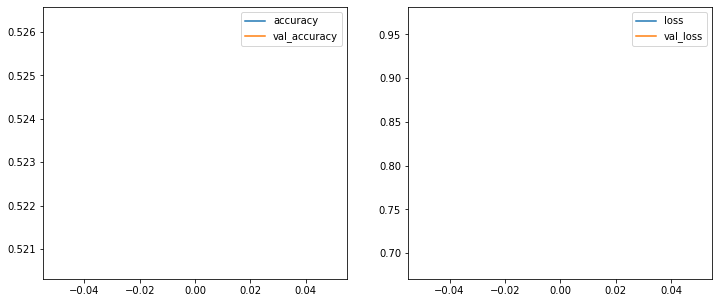

32/32 [==============================] - 9s 274ms/step - loss: 3.2574 - accuracy: 0.6360
The test set accuracy of model is 0.64


In [17]:
# Sanity check

if training:
    plot_history(history)

    model = tf.keras.models.load_model("model.h5")
    check_accuracy(model, 0.50)

In [ ]:
# this cell is for tests


With this model, we reach an accuracy of ~ 0.70 on the test set. From the accuracy and loss plots, we can see that our model is overfitting immediately after the first epochs. \
If you will train the model longer (~300 epochs) you will see that the model will overfit most of the training time, and validation and test accuracy will not improve above 0.70. 

$ $
<figure>
    <img src="../../../coursedata/R4/bs_aug.png" width=600/ align='middle'/>
</figure>


As we are training our model with a relatively small training dataset (~2000 training images), it is not surprising to see overfitting happening. Below, we will try a technique to overcome the problem of overfitting when training with a small dataset (image augmentation). 


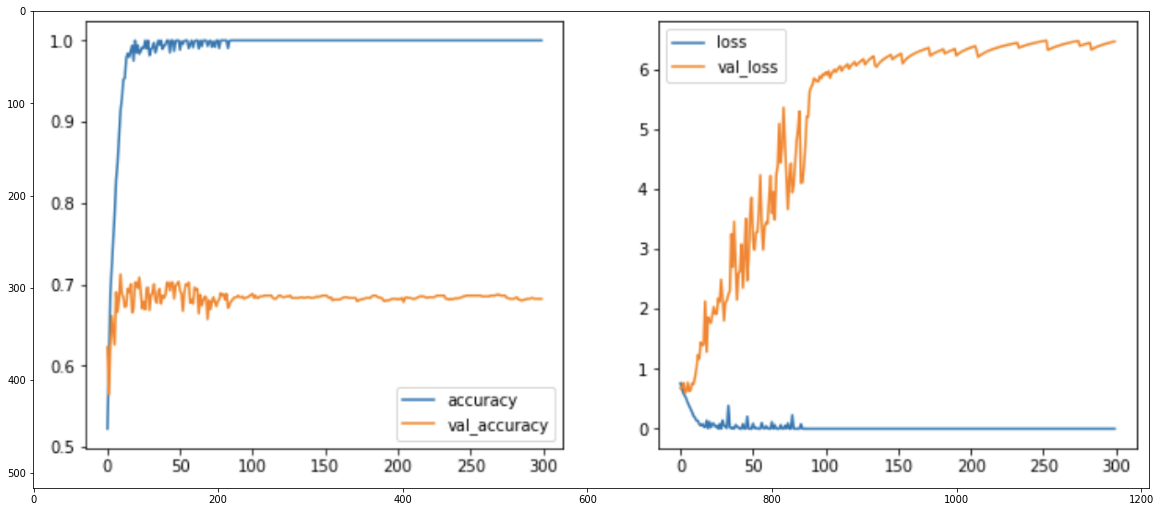

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
MSELinPred_image_prefetch = plt.imread("../../../coursedata/R4/bs_aug.png")
plt.imshow(MSELinPred_image_prefetch)

## CNN training with Data Augmentation

**[Data augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)** is a technique to create new training images by applying random image transformation like random rotation, shifts, shear, and flips, etc. These random image transformations can be combined to make many variants of the original images and transformed images are fed to ANN. Potentially, data augmentation can prevent overfitting. 

There are two ways in which you can use the data augmentation model.

1. Make the preprocessing layers part of your model. In this case, the data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration (if you have one). Additionally, exporting the model will result in saving the preprocessing layers which means that the model will automatically standardize images at a later point.

2. Apply the preprocessing to your dataset, ie., using the data augmentation as the `map_func` for the [Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) function in the training dataset. Using this approach, the data augmentation will happen asynchronously on the CPU and is non-blocking. This means that while the model is being trained with the batch `n`, Tensorflow will be preparing the batch `n+1` in parallel (you need to use [Dataset.prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) to achieve this). 

Both methods can be implemented with Keras Tensorflow :

1. Use the `Sequential` class and the preprocessing module to build a series of data augmentation operations. 
2. Apply transformations with tf.image functions and create the input data pipeline with tf.data.Dataset.

**Note**, that the validation and test data should not be augmented! We augment only the images used for the model training, but not for the model evaluation.

## Data augmentation using Keras layers 

In the preprocessing module, we can find many layers that can be use to apply transformations to images. For example,

* [RandomCrop](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop): Randomly crop the images to target height and width.

* [RandomContrast](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast):  Adjust the contrast of an image or images by a random factor.

* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip): Randomly flip each image horizontally and vertically.

* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation): Randomly rotate each image.

* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling): Multiply inputs by scale and adds offset.

* [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing): Image resizing layer.

You can find the full list of layers in the [tf.keras.layers.experimental.preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module. 

Let's define the `Sequential` model for the data augmentation. As you can see, we are using exactly the same class that we use to create the ANN!

In [19]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        RandomRotation(0.1, fill_mode='constant'),
        RandomZoom(0.1,0.1, fill_mode='constant')
    ]
)

Below we visualize image with applied transformations:

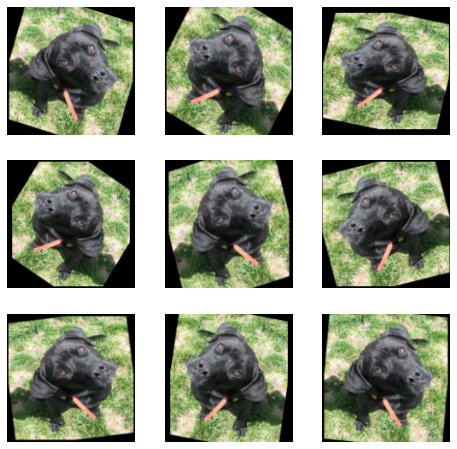

In [20]:
images, _ = train_ds.as_numpy_iterator().next()

plt.figure(figsize=(8, 8))
for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")
plt.show()

<div class=" alert alert-warning">
    <h3><b>Student task.</b> CNN training with Data augmentation.</h3>
        
Your task is to build a Convolutional Neural Network with the following architecture:
       
- `data_augmentation` block defined above. You can add it to Sequential model as any other layer.
- 3 blocks of:
   1. Conv2D layer with 32 units, kernel size (3,3), activation ReLU
   2. Max pooling layer, kernel size (2,2)

    
- flattening layer
- dense layer with 128 units and ReLU activation
- output layer with 1 unit and sigmoid activation
 
    
Use `train_ds` and `val_ds` for training (about 20 epochs). Save your model as 'model_aug.h5'.\
Accuracy evaluated on `test_ds` should be above 0.65.
    
</div>

In [21]:
# YOUR CODE HERE
#raise NotImplementedError()

# define the model architecture using Sequential API
model_aug = tf.keras.models.Sequential([
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="cv1"),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="cv2"),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="cv3"),
    layers.MaxPooling2D(pool_size=2, name="maxpool"),
    layers.Flatten(name="flatten"),
    layers.Dense(128, activation="relu", name="dense"),
    layers.Dense(1, activation='sigmoid', name="output")
])

model_aug.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(),
                  metrics='accuracy')

In [22]:
%%time
# train the CNN (~10 min on CPU)
if training:
    # history = ...
# YOUR CODE HERE
#raise NotImplementedError()
    history = model_aug.fit(train_ds, batch_size=5,epochs=2,verbose=1,validation_data=val_ds)
    model.save('model_aug.h5')
else: 
    model_aug = tf.keras.models.load_model("model_aug.h5")

Epoch 1/2
63/63 [==============================] - 111s 2s/step - loss: 1.9872 - accuracy: 0.5058 - val_loss: 0.8159 - val_accuracy: 0.4985
Epoch 2/2
63/63 [==============================] - 109s 2s/step - loss: 0.7061 - accuracy: 0.5353 - val_loss: 0.9020 - val_accuracy: 0.4975
CPU times: user 9min 15s, sys: 55.4 s, total: 10min 10s
Wall time: 4min 11s


In [ ]:
plot_history(history)
check_accuracy(model_aug, 0.60)

In [ ]:
# this cell is for tests


We see that data augmentation did not improve significantly the accuracy of the model predictions on the validation and test sets, but it did prevent overfitting on the training set.

If you will train the model longer (~300 epochs) you will see that the model will still overfit after 50-100 epochs, but the validation and test accuracy will improve to about 0.75. Data augmentation can not fully prevent overfitting as the augmented images are still highly correlated with the original ones, thus the amount of the new information added is less than, let's say when adding new images.

$ $
<figure>
    <img src="../../../coursedata/R4/keras_aug.png" width=600/ align='middle'/>
</figure>

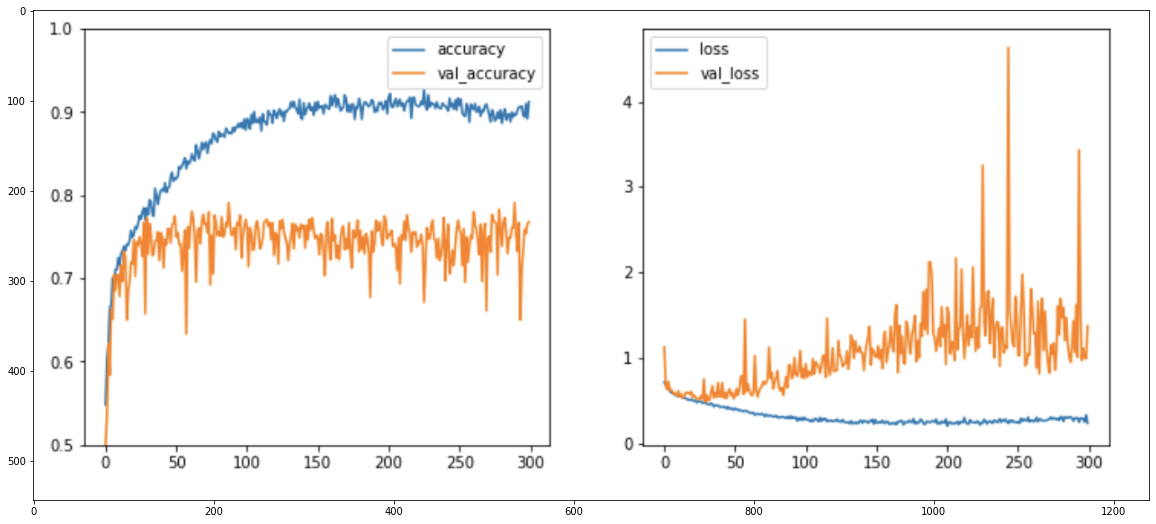

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
MSELinPred_image_prefetch = plt.imread("../../../coursedata/R4/keras_aug.png")
plt.imshow(MSELinPred_image_prefetch)

## Data augmentation using tf.image 

The [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) module contains many functions to perform image processing. We have already seen some of them, like [tf.io.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg) and [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize). We cannot analyze each of them in this notebook, so we encourage you to read the documentation to discover what is available to you! Let's see some of the data augmentation functions in action. But before that, we need to define some auxiliary functions:

In [24]:
image_path = str(train_dir/'cats'/'cat.4.jpg')
image, _ = load_image(image_path)
image = image.numpy()

def visualize(original, augmented):
    plt.figure(figsize=(6, 6))
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")
    plt.show()

<strong>Flipping the image</strong>

Flip the image either vertically or horizontally.

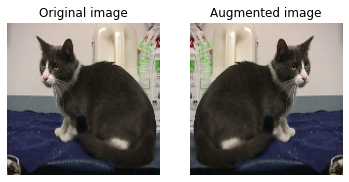

In [25]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

<strong>Saturate the image</strong>

Saturate an image by providing a saturation factor.

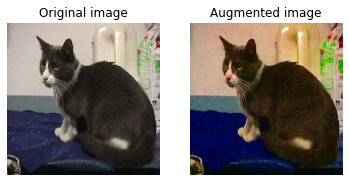

In [26]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

<strong>Center crop the image</strong>

Crop the image from center up to the image part you desire.

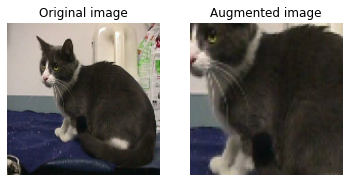

In [27]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

<strong>Rotate the image</strong>

Rotate an image by 90 degrees.

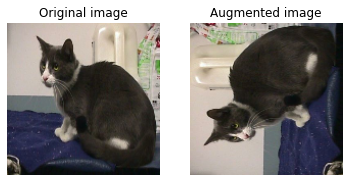

In [28]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In the tutorial [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) from the Tensorflow documentation you can find other examples including functions to perform random transformations similar to the Keras layers.

When we use the `tf.image` module, the data augmentation is not a part of the model, thus we need to create a function that will contain all the transformations we want to apply and then pass it to the `tf.Dataset.map` function. Let's create such function:

In [29]:
def load_image_aug(image_path):
    # load image
    image = tf.io.read_file(image_path)    # read the image from disk
    image = tf.io.decode_jpeg(image, channels=3)   # decode jpeg  
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])    # resize
    
    # transform
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, [120, 120, 3])
    image = tf.image.resize_with_pad(image, 150, 150)
    image = (image / 255.0)    # scale 
    
    # get lable value from path
    parts = tf.strings.split(image_path, os.path.sep)    # parse the class label from the file path
    one_hot = parts[-2] == CLASS_NAMES    # select only part with class name and create boolean array
    label = tf.argmax(one_hot)    # get label as integer from boolean array
    
    return (image, label)

We only need to create a new generator for training dataset, as validation and test sets should not be augmented.

In [30]:
train_ds = tf.data.Dataset.list_files(str(base_dir/'train/*/*.jpg'))

with tf.device('/cpu:0'):
    train_ds = train_ds.map(load_image_aug, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds)

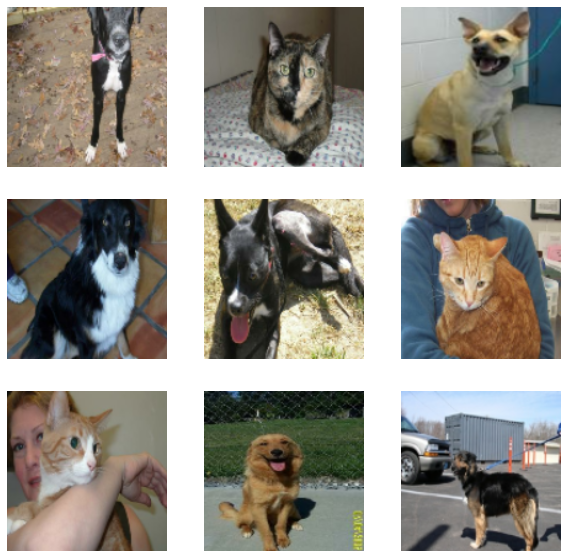

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
plt.show()

Now you can try out `train_ds` generator and train CNN with a similar architecture as in the task "Student task. CNN training without Data augmentation". \
Note, that as augmentation is performed directly by generator, we do not add `data_augmentation` block in CNN model.

After the training you will get plot similar to this one:

$ $
<figure>
    <img src="../../../coursedata/R4/tfdata_aug.png" width=600/ align='middle'/>
</figure>

As you can see, this method is a bit more involved and it requires you to implement the data augmentation pipeline by hand, but the benefit is that you gain more fine-grained control. In most of applications, using the Keras' preprocessing layers is sufficient. 

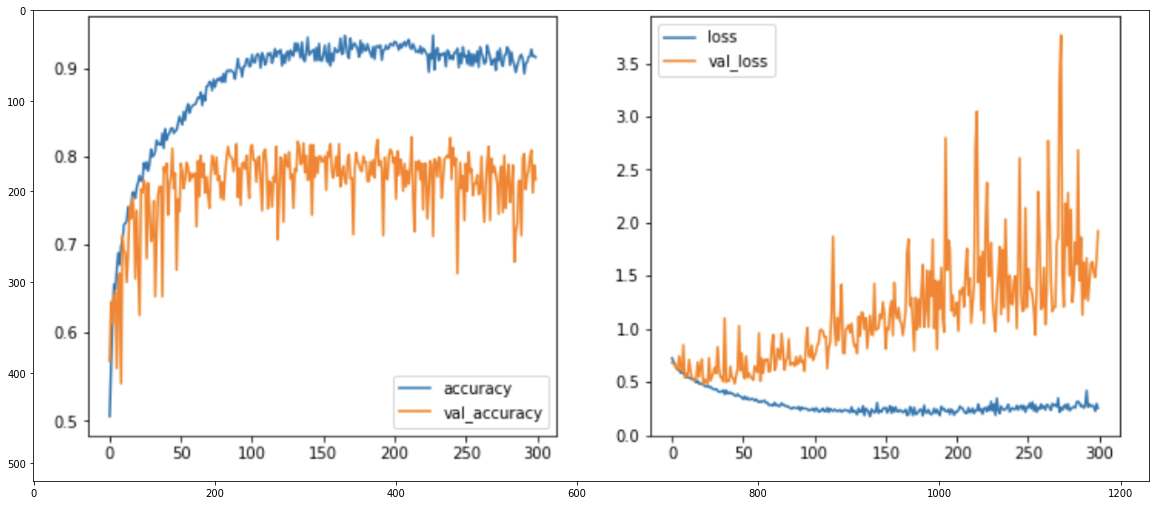

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
MSELinPred_image_prefetch = plt.imread("../../../coursedata/R4/tfdata_aug.png")
plt.imshow(MSELinPred_image_prefetch)

# Summary

In this notebook, we've shown how to create a tf.Dataset and use it for training and validation of the CNN model. The tf.Dataset creates small batches of data to sequentially feed these batches to the neural networks and train the model. They are an effective way to train the model when you have a large dataset and limited computation power. We covered the different ways you can define the data augmentation proccess and we discuss the pros and cons of each approach.

# Quiz

<div class=" alert alert-warning">
    <h3>Question 1.</h3>
        
Choose the correct statement:

1. With limited RAM it is better to feed large datasets to ANN at once (not in batches)

2. With limited RAM it is better to feed large datasets to ANN in batches
    
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
#raise NotImplementedError()

answer_1 = 2

In [ ]:
# This cell is for tests
assert answer_1 in [1,2], '"answer" Value should be an integer between 1 and 2.'
print('Sanity check tests passed!')


<div class=" alert alert-warning">
    <h3>Question 2.</h3>
    
Choose the correct statement:

1. Large training dataset will lead to overfitting

2. Small training dataset will lead to overfitting

3. Large training dataset will lead to worse model generalization

4. Model generalization is better when using small training dataset

</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
#raise NotImplementedError()

answer_2 = 2

In [ ]:
# This cell is for tests
assert answer_2 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class=" alert alert-warning">
    <h3>Question 3.</h3>
    
Choose the correct statement. Image augmentation is:

1. Generating completely new images, not correlated with the original images

2. Used to improve fitting of the training data

3. Improving the colour and brightness of the image

4. Applying random transformations to the images, such as rotation, flipping
    
</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
#raise NotImplementedError()

answer_3 = 4

In [ ]:
# This cell is for tests
assert answer_3 in [1,2,3,4], '"answer" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<div class=" alert alert-warning">
    <h3>Question 4.</h3>
    
Choose the correct statement. Image augmentation does:

1. Does both

2. Adds new images (not correlated with the original images) to the training set

3. Replaces original training images with augmented ones

</div>

In [ ]:
# remove the line raise NotImplementedError() before testing your solution and submitting code

# YOUR CODE HERE
#raise NotImplementedError()

answer_4 = 1

In [ ]:
# This cell is for tests
assert answer_4 in [1,2,3], '"answer" Value should be an integer between 1 and 3.'
print('Sanity check tests passed!')
